# Introduction
Voter Analysis exploration

## Imports
Import libraries and write settings here.

In [21]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

import seaborn as sns


# Data Import and Cleaning

In [2]:
#find the data
path = './data/'
df = pd.read_csv('./data/ccesplus.csv',encoding = "ISO-8859-1")

In [3]:
#get rid of spaces and caps in column names (if any)
df.columns = [col.replace(' ','_').lower() for col in df.columns]

In [4]:
# df.head()
# df.columns
# df.describe()

#any duplicate rows?
df.duplicated().sum()

0

In [5]:
#lets see how many columns, how many have no and some missing values
print (f"Total columns={len(df.columns)}")
print(f"Total columns with no Nans= {len(df.columns[~df.isnull().any()])}") 
print(f"Total columns with Nans= {len(df.columns[df.isnull().any()])}") #add ~ to get columns with no missing values

Total columns=866
Total columns with no Nans= 268
Total columns with Nans= 598


The columns with no NaNs (missing values) are the easiest to use since we dont have to impute missing values

## Get a subset of the rows of the data to work on if desired

In [6]:
#get first thousand rows
# df=df[:1000]

## See what the summary columns do
looks like the summaries (..sum) are just the average

In [7]:
columns=['cc.CC16_422c','cc.CC16_422d','cc.CC16_422e','cc.CC16_422f', 'cc.raceviewsum']
columns = [col.lower() for col in columns]
tmp_df=df[columns]
tmp_df.head()

,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.raceviewsum
0,1.0,2.0,2.0,2.0,1.75
1,1.0,3.0,1.0,2.0,1.75
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,1.0,1.0,1.00


## Get the columns of interest

In [8]:
#contains all the columns that original logits were run on
#use these to start to compare neural network solution
columns = pd.read_excel('./data/results cces.xlsx',encoding = "ISO-8859-1", skiprows=3)
columns = list(columns.iloc[:,0])

#get the dependant variable(s)
# columns_dep_var= ['cc.TrumpGEVote','cc.TrumpPVote', 'cc.vote12.gop']
columns_dep_var= ['cc.trumpgevote']

#combine
columns.extend(columns_dep_var)

#strip rubbish
columns = [col.replace(' ','_').lower() for col in columns]

## Create dataframe for model training

In [9]:
#select out the columns of interest
df_s=df[columns]

In [10]:
len(df_s.iloc[0])

32

### Output some info

In [11]:
# how many unique values there are per column, 
# use that to guide which columns are categorical and which are continuous
#pick largest value that looks continuous, for instance raceviewsum=17 
#(but see the docs many of theses fields are floats which meand fastai ignores cardinality)
for col in df_s.columns:
    print(f"{col}:{df[col].nunique()}")

cc.blackdum:2
econ.mhi:2646
cc.sex:2
cc.maxeduc.4yr:2
econ.hhpov.p:1030
mort.ucd.despair.disc95.pdpy:2660
cc.union:2
cc.age:80
demo.popdense:2668
cc.emp.nojob:2
rustpc:2437
taa.wrks.disc95.pcpy:2120
cc.faminc:16
crashpc:2626
cc.newsint:5
cc.isimmigrant:2
cc.catholic:2
cc.cc16_305_2:2
job.uer:761
cc.child18:2
cc.evanprot:2
cc.whitedum:2
cc.religiosity:15
cc.cc16_351b:2
cc.cc16_307:4
cc.immviewsum:5
cc.cc16_304:5
cc.inddum:2
cc.ideo7:7
cc.raceviewsum:17
cc.repdum:2
cc.trumpgevote:2


In [12]:
#what types are the columns
df_s.dtypes

cc.blackdum                       int64
econ.mhi                        float64
cc.sex                            int64
cc.maxeduc.4yr                    int64
econ.hhpov.p                    float64
mort.ucd.despair.disc95.pdpy    float64
cc.union                        float64
cc.age                            int64
demo.popdense                   float64
cc.emp.nojob                      int64
rustpc                          float64
taa.wrks.disc95.pcpy            float64
cc.faminc                       float64
crashpc                         float64
cc.newsint                      float64
cc.isimmigrant                    int64
cc.catholic                     float64
cc.cc16_305_2                     int64
job.uer                         float64
cc.child18                      float64
cc.evanprot                     float64
cc.whitedum                       int64
cc.religiosity                  float64
cc.cc16_351b                    float64
cc.cc16_307                     float64


In [13]:
#the percentage of NaNs in each column, note the large percentage of missing values in the bottom columns
#I would guess that cc.faminc and cc.raceviewsum are critical
df_s.isna().sum().sort_values(ascending = True)/len(df)

cc.blackdum                     0.000000
cc.immviewsum                   0.000000
cc.whitedum                     0.000000
cc.cc16_305_2                   0.000000
cc.emp.nojob                    0.000000
cc.age                          0.000000
cc.isimmigrant                  0.000000
cc.sex                          0.000000
cc.maxeduc.4yr                  0.000000
cc.evanprot                     0.000666
cc.newsint                      0.000820
cc.catholic                     0.001130
demo.popdense                   0.001300
econ.hhpov.p                    0.001300
econ.mhi                        0.001300
taa.wrks.disc95.pcpy            0.001300
job.uer                         0.001300
cc.cc16_307                     0.001517
mort.ucd.despair.disc95.pdpy    0.001548
cc.child18                      0.001827
cc.cc16_351b                    0.001950
cc.cc16_304                     0.002059
cc.union                        0.002136
crashpc                         0.002229
rustpc          

In [14]:
#BUMMER! the dependant variable has a lot of missing values (36.7%)
df_s['cc.trumpgevote'].unique()

array([nan,  1.,  0.])

## Remove NaN dependent variable rows
whaddaya going to do?  You have no way of knowing how these people voted

In [15]:
print(f"There are {len(df_s)} rows in df_s")

There are 64600 rows in df_s


In [16]:
#dump the NaN rows
df_s = df_s[pd.notnull(df_s['cc.trumpgevote'] )]

In [17]:
#convert trumpgevote to long (otherwise fit fails)
df_s['cc.trumpgevote'] = df_s['cc.trumpgevote'].astype('int64');

In [18]:
#causes nan for learner
# df_s['cc.trumpgevote'] = df_s['cc.trumpgevote'].astype('category');
# df_s['cc.trumpgevote'].cat.categories

In [26]:
#is the dataset balanced?
df_vc= df_s['cc.trumpgevote'].value_counts()
df_vc[0]
df_vc[1]

22136

18754

In [28]:
#how about as percentages
print(f"total percentage of people who voted for trump in this datasets={100*df_vc[0]/(df_vc[0]+df_vc[1])}")

total percentage of people who voted for trump=54.13548544876498


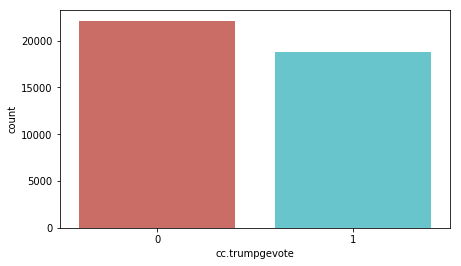

In [23]:
#lets see that as a graph
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(x='cc.trumpgevote', data=df_s, palette='hls')

## Split out categorical and continuous variables
see if fastai can auto do it

In [20]:
#give fastai a shot at splitting cat and cont variables
res_cont, res_cat = cont_cat_split(df_s,max_card=18)

In [21]:
# ??cont_cat_split

In [22]:
print(res_cont)
print(res_cat)

['econ.mhi', 'econ.hhpov.p', 'mort.ucd.despair.disc95.pdpy', 'cc.union', 'cc.age', 'demo.popdense', 'rustpc', 'taa.wrks.disc95.pcpy', 'cc.faminc', 'crashpc', 'cc.newsint', 'cc.catholic', 'job.uer', 'cc.child18', 'cc.evanprot', 'cc.religiosity', 'cc.cc16_351b', 'cc.cc16_307', 'cc.immviewsum', 'cc.cc16_304', 'cc.inddum', 'cc.ideo7', 'cc.raceviewsum', 'cc.repdum']
['cc.blackdum', 'cc.sex', 'cc.maxeduc.4yr', 'cc.emp.nojob', 'cc.isimmigrant', 'cc.cc16_305_2', 'cc.whitedum', 'cc.trumpgevote']


In [23]:
#remove the dependant variable
res_cont = [x for x in res_cont if x not in columns_dep_var]
res_cat = [x for x in res_cat if x not in columns_dep_var]

In [24]:
df_s.head()
len(df_s)

,cc.blackdum,econ.mhi,cc.sex,cc.maxeduc.4yr,econ.hhpov.p,mort.ucd.despair.disc95.pdpy,cc.union,cc.age,demo.popdense,cc.emp.nojob,rustpc,taa.wrks.disc95.pcpy,cc.faminc,crashpc,cc.newsint,cc.isimmigrant,cc.catholic,cc.cc16_305_2,job.uer,cc.child18,cc.evanprot,cc.whitedum,cc.religiosity,cc.cc16_351b,cc.cc16_307,cc.immviewsum,cc.cc16_304,cc.inddum,cc.ideo7,cc.raceviewsum,cc.repdum,cc.trumpgevote
1,0,NaN,1,1,NaN,NaN,1.0,64,NaN,0,NaN,NaN,NaN,NaN,1.0,0,0.0,0,NaN,0.0,1.0,1,16.0,1.0,4.0,0.50,3.0,0.0,7.0,1.75,1.0,1
4,0,NaN,0,1,NaN,NaN,0.0,75,NaN,0,NaN,NaN,8.0,NaN,1.0,0,0.0,0,NaN,0.0,0.0,1,11.0,0.0,4.0,0.00,1.0,0.0,1.0,1.00,0.0,0
7,0,NaN,1,1,NaN,NaN,1.0,81,NaN,0,NaN,NaN,NaN,NaN,1.0,0,0.0,0,NaN,0.0,0.0,1,16.0,1.0,4.0,0.75,4.0,1.0,6.0,2.50,0.0,1
9,0,NaN,0,0,NaN,NaN,0.0,39,NaN,0,NaN,NaN,10.0,NaN,1.0,0,0.0,0,NaN,1.0,0.0,1,7.0,0.0,3.0,0.00,3.0,1.0,4.0,1.75,0.0,0
11,0,NaN,1,0,NaN,NaN,0.0,66,NaN,0,NaN,NaN,8.0,NaN,1.0,0,0.0,0,NaN,0.0,0.0,1,15.0,0.0,3.0,0.75,3.0,1.0,4.0,2.00,0.0,0


40890

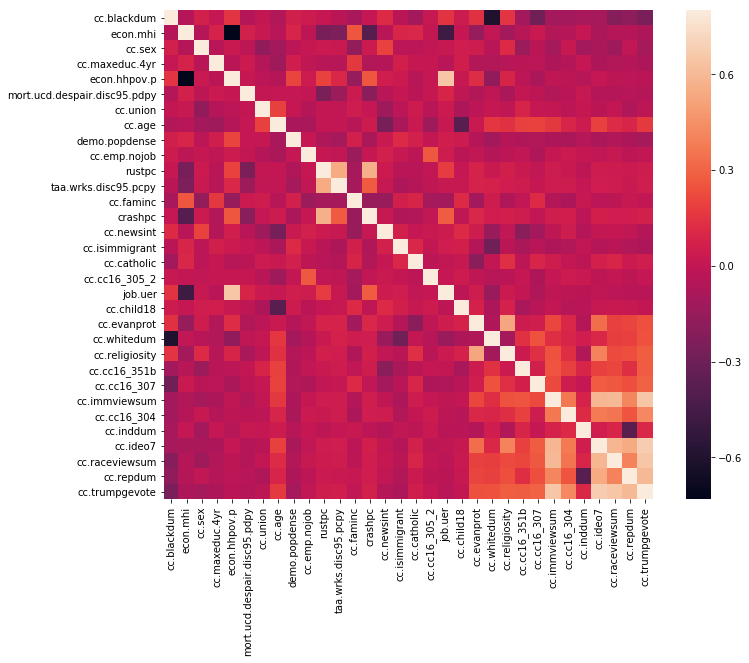

In [31]:
#correlation matrix
corrmat = df_s.corr(method='pearson')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

#there is a lot of correlation here,the darks and the lights

## Split out train/test sets for consistency
Neural Nets, Random Forest, etc will use same sets, so result differnces cannot be attributed to different splits

In [25]:
# split out train/test sets
from sklearn.model_selection import train_test_split

train,tst = train_test_split(df_s, test_size=0.1)
print(str(len(train)))
print(str(len(tst)))

36801
4089


# Save train/test and catagorical and continuous column names

In [26]:
os.makedirs('tmp', exist_ok=True)

train.reset_index(inplace=True,drop=True)
train.to_feather('tmp/train')

tst.reset_index(inplace=True,drop=True)
tst.to_feather('tmp/tst')

In [27]:
import simplejson
with open('tmp/catcont.json','w') as f:
    json.dump((res_cont,res_cat,columns_dep_var), f)
    

# Results
Show graphs and stats here